## Credit Risk Model

#### Importing necessary libraries

In [1]:
import os
import sys
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scorecardpy as sc

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, f1_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sys.path.append(os.path.abspath('../scripts'))

from Utils import DataUtils, WoE
from Plotting import Plots
from Modelling import Evaluation

data_utils = DataUtils()
plotting = Plots()
evaluation = Evaluation()


#### Modelling

In [4]:
filepath = '../data/data.csv'

data = data_utils.load_data(filepath)
data.drop('TransactionStartTime', inplace=True, axis=1)

2024-10-08 12:41 - DEBUG :: Loading data from file...


#### From the selecteed columns from the scorecard let's visualize the correlation

2024-10-08 12:42 - DEBUG :: Plotting Heatmap for numerical columns
2024-10-08 12:42 - DEBUG :: locator: <matplotlib.ticker.AutoLocator object at 0x000001FB9C74AC90>


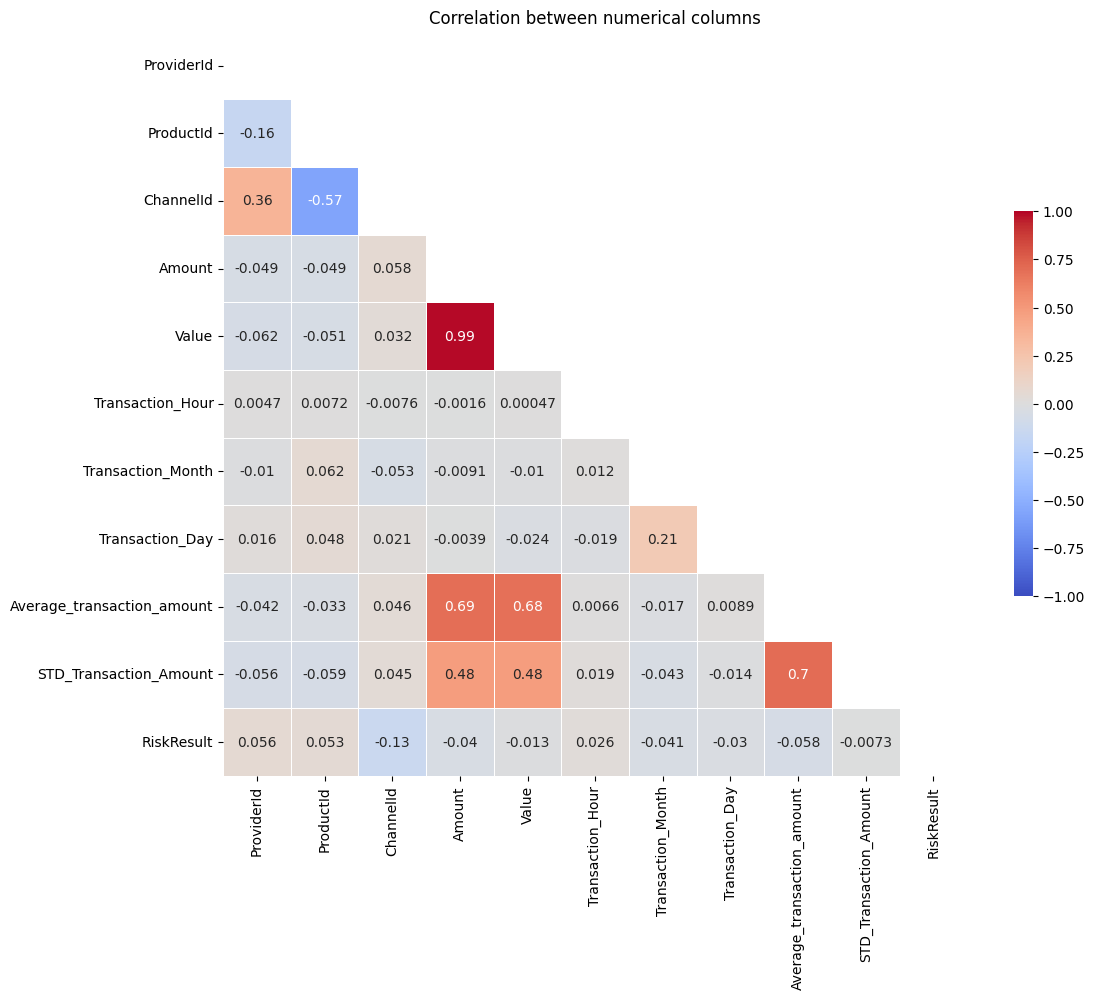

In [6]:
col =  ['ProviderId', 'ProductId', 'ChannelId', 'Amount', 'Value','Transaction_Hour', 'Transaction_Month',	'Transaction_Day',  'Average_transaction_amount', 'STD_Transaction_Amount', 'RiskResult']
plotting.visualize_correlations(data, col, huge_col = True)

**Observation**
- From the above columns we will use the columns that are not correlated to train our models.
    * Recency and trasaction month have high correlation: 
        - While choosing between the two variable we will choose Recency because Recency(IV = 0.3) has more Iv value compared to trasaction month(IV = 0.2)
- Amount and value are highly correlated so we will use Amount since it conveys more data.

In [7]:
# From the scorecard we will drop columns that have weak predictive power
# Scorecard is computed on the WoE_and_Iv notebook


feature_col = ['ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Amount', 'Transaction_Hour', 'Transaction_Day', 'Average_transaction_amount', 'STD_Transaction_Amount', 'Transaction_Month']
target_col = 'RiskResult'
all_cols = ['ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Amount', 'Transaction_Hour', 'Transaction_Day', 'Average_transaction_amount', 'STD_Transaction_Amount', 'Transaction_Month', 'RiskResult']
# Data for training modles
model_data = data[all_cols]

In [8]:
model_data.duplicated().sum()

np.int64(17561)

In [9]:
model_data = model_data.drop_duplicates()
model_data.shape

(78101, 11)

In [10]:
model_data['STD_Transaction_Amount'] = model_data['STD_Transaction_Amount'].fillna(0)

In [12]:
continuous_features = ['Amount', 'Transaction_Hour', 'Transaction_Day', 
                        'Average_transaction_amount', 'STD_Transaction_Amount', 'Transaction_Month']


scaler = StandardScaler()
model_data[continuous_features] = scaler.fit_transform(model_data[continuous_features])

In [13]:
# Encode categorical cols: ProductCategory
model_data = pd.get_dummies(model_data)

In [14]:
X = model_data.drop(target_col, axis=1)
y = model_data[target_col]


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

#### Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

In [16]:
evaluation.evaluate(y_pred, y_test, X_test, lr_model)


Accuracy      : 0.8067
Precision     : 0.5735
Recall        : 0.0129
F1 Score      : 0.0252
Roc Auc Score : 0.6772


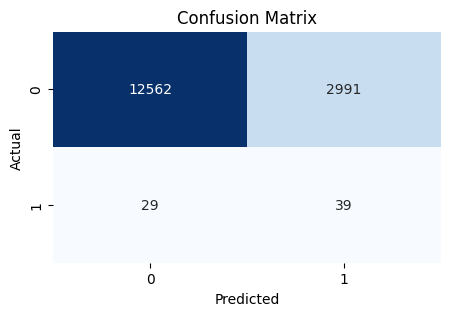

In [17]:
evaluation.plot_confusion_matrix(y_pred, y_test)

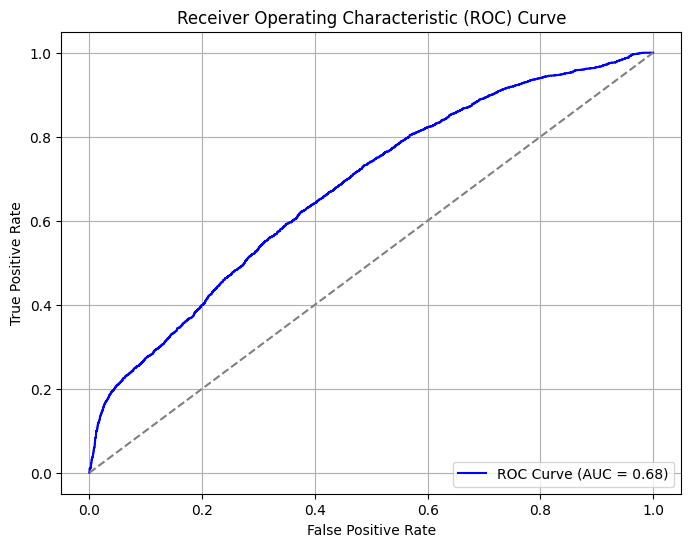

In [18]:
evaluation.plot_roc_curve(y_test, X_test, lr_model)

**Observation**
- logistic regression has lesser Roc auc curve

In [19]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(random_state=0)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [21]:
y_pred = tree_model.predict(X_test)
evaluation.evaluate(y_pred, y_test, X_test, tree_model)

Accuracy      : 0.9987
Precision     : 0.9964
Recall        : 0.9967
F1 Score      : 0.9965
Roc Auc Score : 0.9979


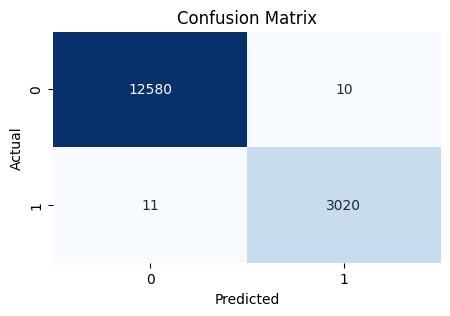

In [22]:
evaluation.plot_confusion_matrix(y_pred, y_test)

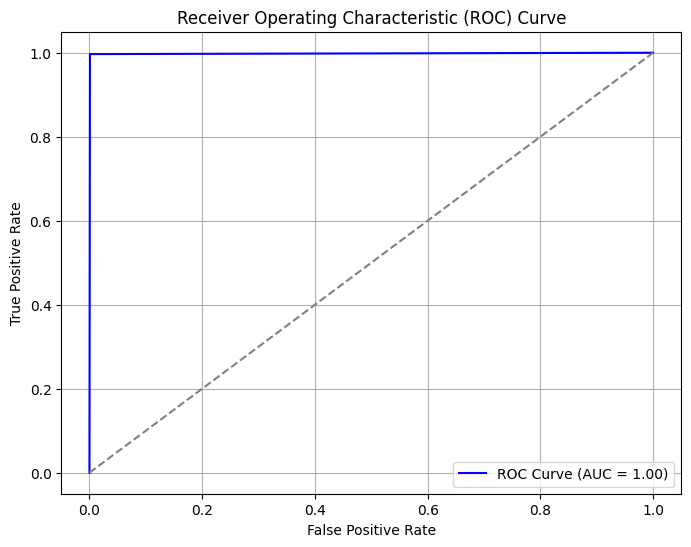

In [23]:
evaluation.plot_roc_curve(y_test, X_test, tree_model)

In [24]:
from sklearn.ensemble import RandomForestClassifier
forest_model = RandomForestClassifier( random_state=0, n_jobs=-1)
forest_model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [25]:
y_pred = forest_model.predict(X_test)
evaluation.evaluate(y_pred, y_test, X_test, forest_model)

Accuracy      : 0.9867
Precision     : 0.9910
Recall        : 0.9403
F1 Score      : 0.9649
Roc Auc Score : 0.9990


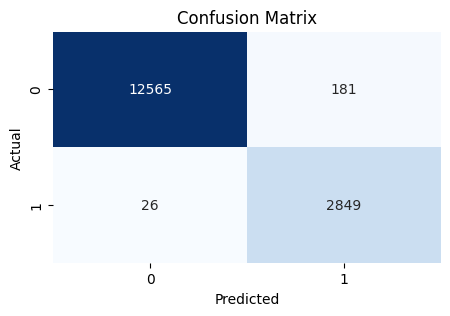

In [26]:
evaluation.plot_confusion_matrix(y_pred, y_test)

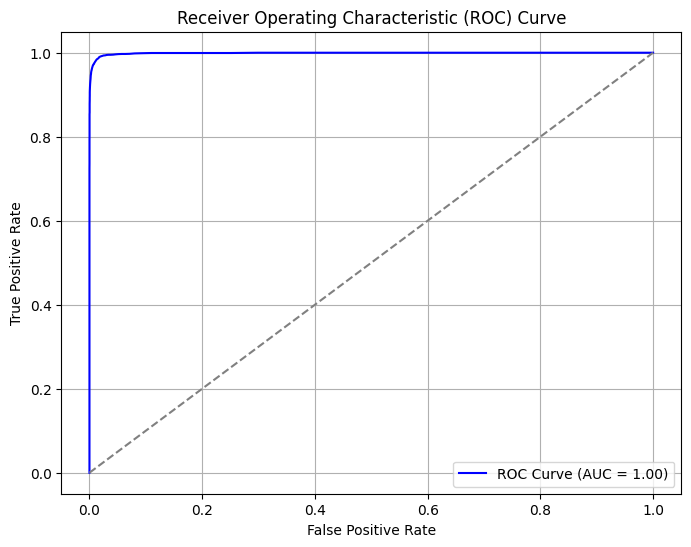

In [27]:
evaluation.plot_roc_curve(y_test, X_test, forest_model)

**Observation**
- Random forest and decision tree overfit

In [28]:
from sklearn.ensemble import GradientBoostingClassifier

GB_model =  GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
GB_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [29]:
y_pred = GB_model.predict(X_test)
evaluation.evaluate(y_pred, y_test, X_test, GB_model)

Accuracy      : 0.9473
Precision     : 0.9686
Recall        : 0.7525
F1 Score      : 0.8470
Roc Auc Score : 0.9783


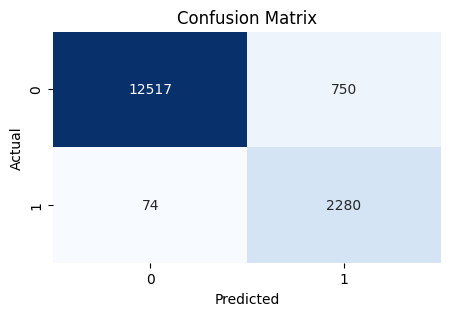

In [30]:
evaluation.plot_confusion_matrix(y_pred, y_test)

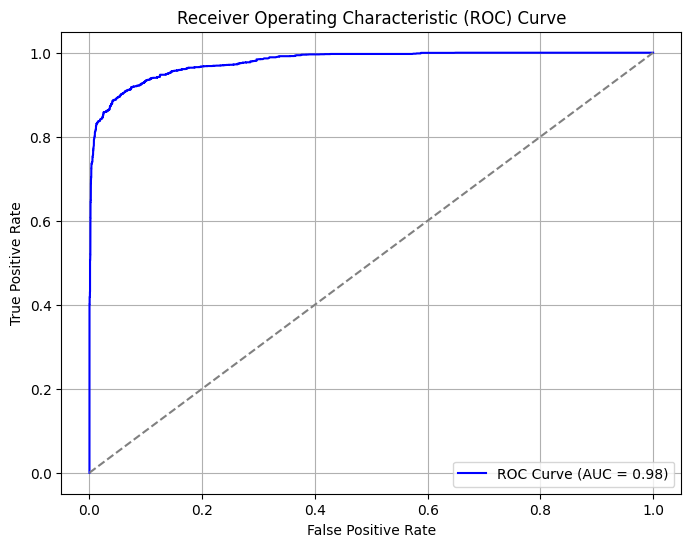

In [31]:
evaluation.plot_roc_curve(y_test, X_test, GB_model)

**Observation**
- GradientBoostingClassifier is the best classifier for this task